### Algorithm setup

In [1]:
import numpy as np

# Structural parameters
A     = 1    # productivity
alfa  = 0.3  # capital share
sigma = 2    # CRRA
rho   = 0.05 # discount rate
delta = 0.05 # depreciation rate

# solve for cstar, kstar
kstar = ((alfa*A)/(rho+delta))**(1/(1-alfa))
cstar = A*kstar**alfa - delta*kstar

# initial condition
gamma = 1/2
k0 = gamma*kstar # start with gamma the steady state capital stock

# finite diff parameters
dt     = 0.1  # time interval 
N      = 700  # number of time gridpoints
i      = 0    # set number of iterations to 0
it_max = int(1e4)  # maximum number of iterations to run the algorithm
tol    = 1e-3 # tolerance value for distance to ss
cdist  = 100  # arbitrary initial value of cdist must be greater than ctol
kdist  = 100  # arbitrary initial value of cdist must be greater than ctol

# initialize grids for c and k (preallocation speeds up the algorithm)
c0    = np.zeros((it_max,1)); 
c     = np.zeros((N,it_max+1));
k     = np.zeros((N,it_max+1));

k[0,:] = k0

# initial boundaries for initial guess of consumption
c_under = 0  # c0 cannot be negative
c_over  = A*k0**(alfa) - delta*k0  # c0 should be maximum feasible consumption given k0

In [2]:
kstar*delta

0.24019933283365458

### Shooting algorithm

In [3]:
while (i < it_max) and (cdist > tol) and (kdist > tol):
    
    # i. guess c0:
    c0[i] = (c_over+c_under)/2 
    c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
    
    # ii. obtain cn and kn by running FD forward in time:
    # exercise: make the code more robust by asserting nonnegativity
    # constraints
    for n in range(N-1):
        c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
        k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]

        if c[n,i] > c[n+1,i]:
            c_under = c0[i][0]
            break
        elif k[n,i] > k[n+1,i]:
            c_over  = c0[i][0]
            break
    
    # iii. check for convergence
    if not np.isnan(c[N-1,i]) and not np.isnan(k[N-1,i]):
        cdist = abs(c[N-1,i] - cstar)/(c[N-1,i]+cstar)
        kdist = abs(k[N-1,i] - kstar)/(k[N-1,i]+kstar)
    
    if sum(c[:,i] > cstar) > 0:
        c_over  = c0[i][0] # if consumption ever exceeds cstar, initial guess of c0 was too high
    elif sum(k[:,i] > kstar) > 0:
        c_under = c0[i][0] # if capital ever exceeds kstar, initial guess of c0 was too low
    
    i = i + 1 # update count of iterations and try again   
    
k_path = k[:,i-1]
c_path = c[:,i-1]

C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\2489961364.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[0,i]= c0[i]  # update c(1) sequence with new c0 guess


### Plotting functions

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_capital(k_paths, kstar, labels, ax):
    L = len(k_paths[0])
    star = np.linspace(kstar,kstar,L)
    for path, label in zip(k_paths, labels):
        ax.plot(path, label=label)
    ax.plot(star, label=f"Steady state capital")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Capital")
    ax.set_ylim(bottom=max(min([item for sublist in k_paths for item in sublist])*0.9,0))
    ax.legend(loc="lower right")

In [6]:
def plot_capital_ratio(k_paths, labels, ax):
    L = len(k_paths[0])
    star = np.linspace(1,1,L)
    for path, label in zip(k_paths, labels):
        ax.plot(path, label=label)
    ax.plot(star, label=f"Capital = Steady state capital")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Capital / (Steady state capital)")
    ax.set_ylim(bottom=max(min([item for sublist in k_paths for item in sublist])*0.9,0))
    ax.legend(loc="lower right")

In [7]:
def plot_consumption(c_paths, cstar, labels, ax):
    L = len(c_paths[0])
    star = np.linspace(cstar,cstar,L)
    for path, label in zip(c_paths, labels):
        ax.plot(path, label=label)
    ax.plot(star, label=f"Steady state consumption")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Consumption")
    ax.set_ylim(bottom=max(min([item for sublist in c_paths for item in sublist]),0), 
                top=min(max([item for sublist in c_paths for item in sublist]),cstar*2))
    ax.legend(loc="lower right")

In [8]:
def plot_consumption_ratio(c_paths, labels, ax):
    L = len(c_paths[0])
    star = np.linspace(1,1,L)
    for path, label in zip(c_paths, labels):
        ax.plot(path, label=label)
    ax.plot(star, label=f"Consumption = Steady state consumption")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Consumption / (Steady state consumption)")
    ax.set_ylim(bottom=max(min([item for sublist in c_paths for item in sublist])*0.9,0))
    ax.legend(loc="lower right")

### 2(b)

In [9]:
import numpy as np

# Structural parameters
A     = 1    # productivity
alfa  = 1/3  # capital share
sigmas = [0.01,1.01,2,3,4,10] # CRRA
rho   = (1-0.96)/0.96 # discount rate
delta = 0.08 # depreciation rate

# solve for cstar, kstar
kstar_2b = ((alfa*A)/(rho+delta))**(1/(1-alfa))
cstar_2b = A*kstar_2b**alfa - delta*kstar_2b

# initial condition
gamma = 1/2
k0 = gamma*kstar_2b # start with gamma the steady state capital stock

# initialise list of capital and consumption paths
k_paths_2b = []
c_paths_2b = []

for sigma in sigmas:
    # finite diff parameters
    dt     = 0.1  # time interval 
    N      = 1000  # number of time gridpoints
    i      = 0    # set number of iterations to 0
    it_max = int(1e4)  # maximum number of iterations to run the algorithm
    tol    = 1e-3 # tolerance value for distance to ss
    cdist  = 100  # arbitrary initial value of cdist must be greater than ctol
    kdist  = 100  # arbitrary initial value of cdist must be greater than ctol

    # initialize grids for c and k (preallocation speeds up the algorithm)
    c0    = np.zeros((it_max,1)); 
    c     = np.zeros((N,it_max+1));
    k     = np.zeros((N,it_max+1));

    k[0,:] = k0

    # initial boundaries for initial guess of consumption
    c_under = 0  # c0 cannot be negative
    c_over  = A*k0**(alfa) - delta*k0  # c0 should be maximum feasible consumption given k0

    while (i < it_max) and (cdist > tol) and (kdist > tol):
    
        # i. guess c0:
        c0[i] = (c_over+c_under)/2 
        c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
        
        if i>1 and c0[i] == c0[i-1]:
            break

        # ii. obtain cn and kn by running FD forward in time:
        # exercise: make the code more robust by asserting nonnegativity
        # constraints
        for n in range(N-1):
            c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
            k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]

            if c[n,i] > c[n+1,i]:
                c_under = c0[i][0]
#                 break
            elif k[n,i] > k[n+1,i]:
                c_over  = c0[i][0]
#                 break

        # iii. check for convergence
        if not np.isnan(c[N-1,i]) and not np.isnan(k[N-1,i]):
            cdist = abs(c[N-1,i] - cstar_2b)/(c[N-1,i]+cstar_2b)
            kdist = abs(k[N-1,i] - kstar_2b)/(k[N-1,i]+kstar_2b)

        if sum(c[:,i] > cstar_2b) > 0:
            c_over  = c0[i][0] # if consumption ever exceeds cstar, initial guess of c0 was too high
        elif sum(k[:,i] > kstar_2b) > 0:
            c_under = c0[i][0] # if capital ever exceeds kstar, initial guess of c0 was too low

        i = i + 1 # update count of iterations and try again

    k_paths_2b.append(k[:,i-1])
    c_paths_2b.append(c[:,i-1])

C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\1210309883.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\1210309883.py:56: RuntimeWarning: invalid value encountered in scalar power
  c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\1210309883.py:57: RuntimeWarning: invalid value encountered in scalar power
  k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]


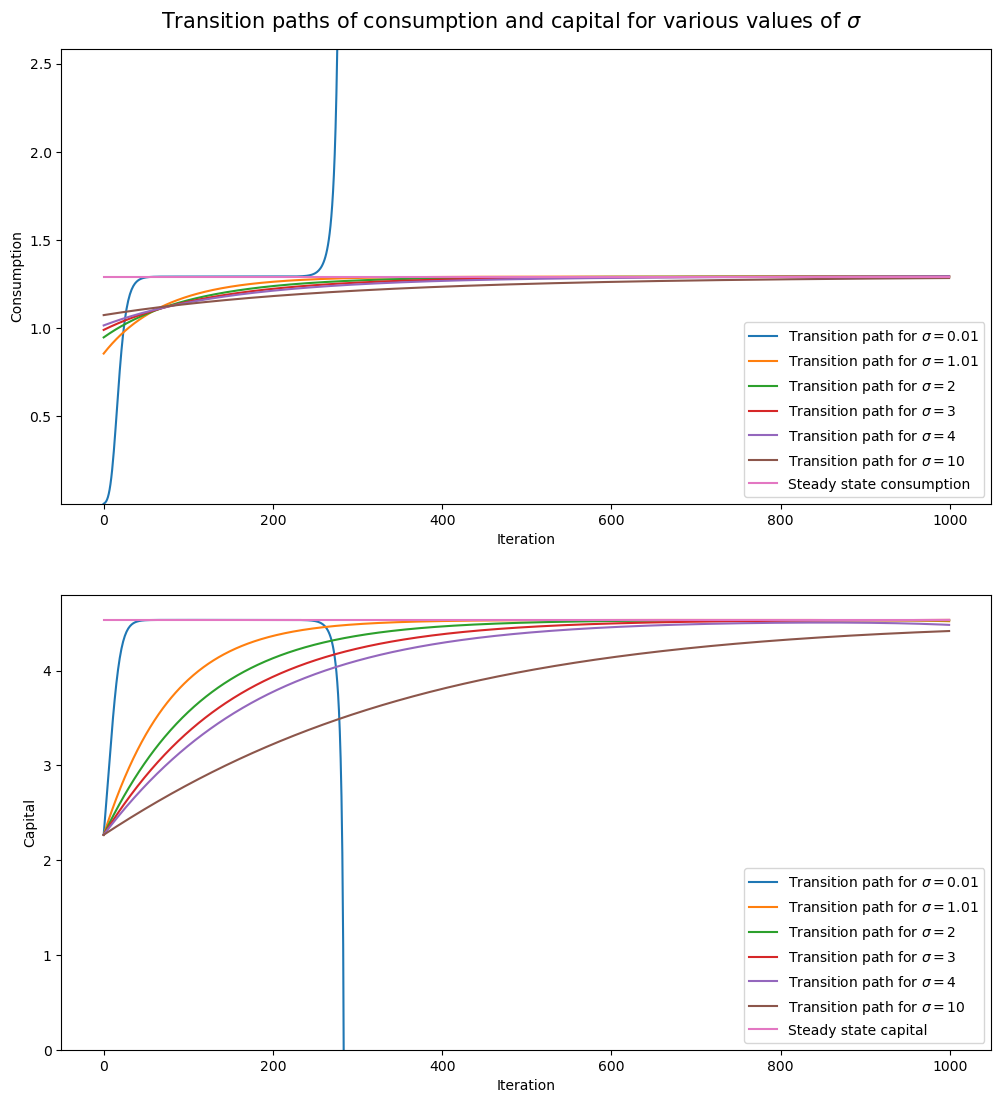

In [10]:
labels = [f"Transition path for $\sigma={sigma}$" for sigma in sigmas]
fig, axs = plt.subplots(2,1,figsize=(12,13))
plot_capital(k_paths_2b, kstar_2b, labels, axs[1])
plot_consumption(c_paths_2b, cstar_2b, labels, axs[0])
fig.suptitle("Transition paths of consumption and capital for various values of $\sigma$", y=0.91, size=15)
fig.savefig("PS2_2b.png")

### 2(c)

In [11]:
import numpy as np

# Structural parameters
A     = 1    # productivity
alfas  = [0.2,0.4,0.6,0.8]  # capital share
sigma = 1.01 # CRRA
rho   = (1-0.96)/0.96 # discount rate
delta = 0.08 # depreciation rate

# initialise list of capital and consumption paths
k_paths_2c = []
c_paths_2c = []

for alfa in alfas:
    # solve for cstar, kstar
    kstar = ((alfa*A)/(rho+delta))**(1/(1-alfa))
    cstar = A*kstar**alfa - delta*kstar

    # initial condition
    gamma = 1/2
    k0 = gamma*kstar # start with gamma the steady state capital stock
    
    # finite diff parameters
    dt     = 0.1  # time interval 
    N      = 1000  # number of time gridpoints
    i      = 0    # set number of iterations to 0
    it_max = int(1e4)  # maximum number of iterations to run the algorithm
    tol    = 1e-3 # tolerance value for distance to ss
    cdist  = 100  # arbitrary initial value of cdist must be greater than ctol
    kdist  = 100  # arbitrary initial value of cdist must be greater than ctol

    # initialize grids for c and k (preallocation speeds up the algorithm)
    c0    = np.zeros((it_max,1)); 
    c     = np.zeros((N,it_max+1));
    k     = np.zeros((N,it_max+1));

    k[0,:] = k0

    # initial boundaries for initial guess of consumption
    c_under = 0  # c0 cannot be negative
    c_over  = A*k0**(alfa) - delta*k0  # c0 should be maximum feasible consumption given k0

    while (i < it_max) and (cdist > tol) and (kdist > tol):
    
        # i. guess c0:
        c0[i] = (c_over+c_under)/2 
        c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
        
        if i>1 and c0[i] == c0[i-1]:
            break

        # ii. obtain cn and kn by running FD forward in time:
        # exercise: make the code more robust by asserting nonnegativity
        # constraints
        for n in range(N-1):
            c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
            k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]

            if c[n,i] > c[n+1,i]:
                c_under = c0[i][0]
#                 break
            elif k[n,i] > k[n+1,i]:
                c_over  = c0[i][0]
#                 break

        # iii. check for convergence
        if not np.isnan(c[N-1,i]) and not np.isnan(k[N-1,i]):
            cdist = abs(c[N-1,i] - cstar)/(c[N-1,i]+cstar)
            kdist = abs(k[N-1,i] - kstar)/(k[N-1,i]+kstar)

        if sum(c[:,i] > cstar) > 0:
            c_over  = c0[i][0] # if consumption ever exceeds cstar, initial guess of c0 was too high
        elif sum(k[:,i] > kstar) > 0:
            c_under = c0[i][0] # if capital ever exceeds kstar, initial guess of c0 was too low

        i = i + 1 # update count of iterations and try again

    k_paths_2c.append(k[:,i-1]/kstar)
    c_paths_2c.append(c[:,i-1]/cstar)

C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\1832792714.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\1832792714.py:56: RuntimeWarning: invalid value encountered in scalar power
  c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\1832792714.py:57: RuntimeWarning: invalid value encountered in scalar power
  k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]


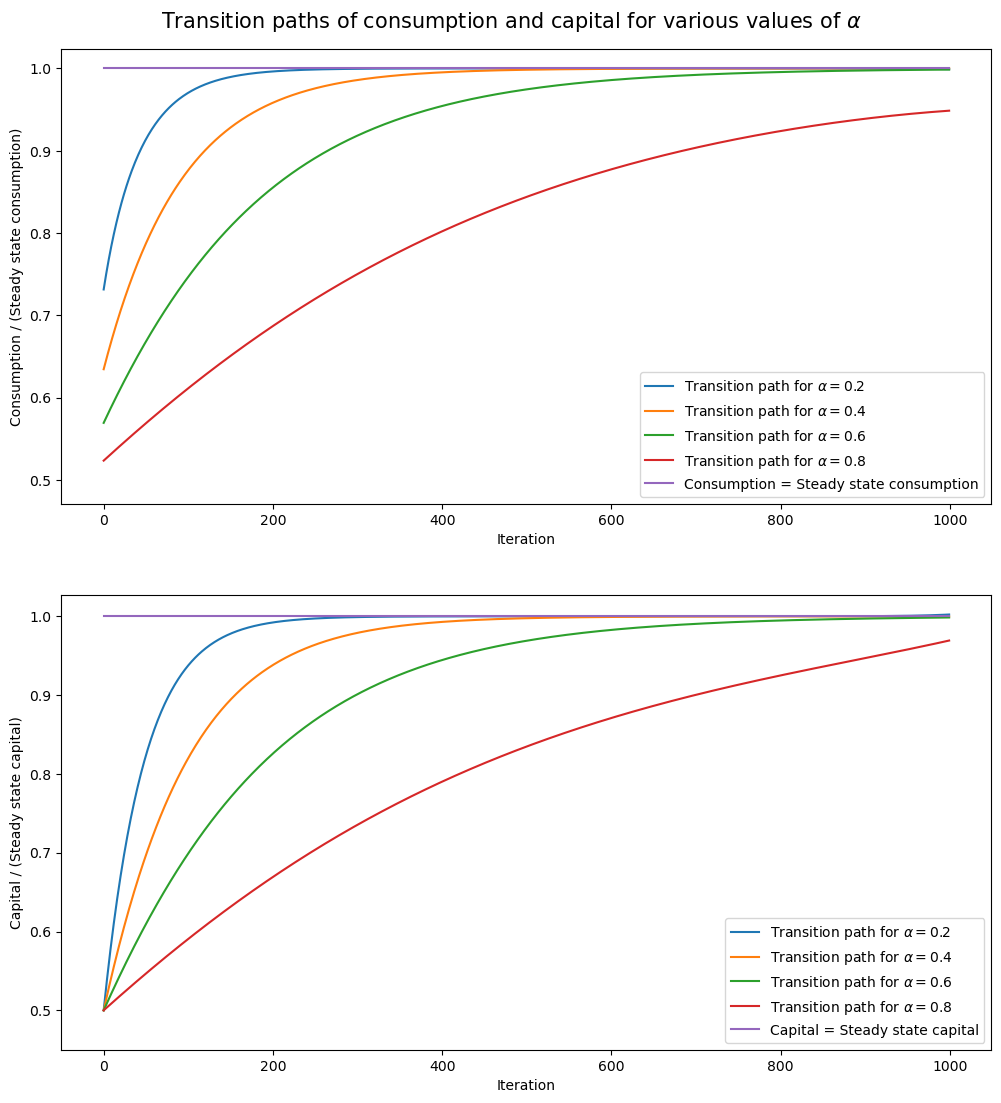

In [12]:
labels = [rf"Transition path for $\alpha={alfa}$" for alfa in alfas]
fig, axs = plt.subplots(2,1,figsize=(12,13))
plot_capital_ratio(k_paths_2c, labels, axs[1])
plot_consumption_ratio(c_paths_2c, labels, axs[0])
fig.suptitle(r"Transition paths of consumption and capital for various values of $\alpha$", y=0.91, size=15)
fig.savefig("PS2_2c.png")

### 2(d)

In [13]:
import numpy as np

# Structural parameters
As     = [1,2,3,4]    # productivity
alfa  = 1/3  # capital share
sigma = 1.01 # CRRA
rho   = (1-0.96)/0.96 # discount rate
delta = 0.08 # depreciation rate

# initialise list of capital and consumption paths
k_paths_2d = []
c_paths_2d = []

for A in As:
    # solve for cstar, kstar
    kstar = ((alfa*A)/(rho+delta))**(1/(1-alfa))
    cstar = A*kstar**alfa - delta*kstar

    # initial condition
    gamma = 1/2
    k0 = gamma*kstar # start with gamma the steady state capital stock
    
    # finite diff parameters
    dt     = 0.1  # time interval 
    N      = 1000  # number of time gridpoints
    i      = 0    # set number of iterations to 0
    it_max = int(1e4)  # maximum number of iterations to run the algorithm
    tol    = 1e-3 # tolerance value for distance to ss
    cdist  = 100  # arbitrary initial value of cdist must be greater than ctol
    kdist  = 100  # arbitrary initial value of cdist must be greater than ctol

    # initialize grids for c and k (preallocation speeds up the algorithm)
    c0    = np.zeros((it_max,1)); 
    c     = np.zeros((N,it_max+1));
    k     = np.zeros((N,it_max+1));

    k[0,:] = k0

    # initial boundaries for initial guess of consumption
    c_under = 0  # c0 cannot be negative
    c_over  = A*k0**(alfa) - delta*k0  # c0 should be maximum feasible consumption given k0

    while (i < it_max) and (cdist > tol) and (kdist > tol):
    
        # i. guess c0:
        c0[i] = (c_over+c_under)/2 
        c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
        
        if i>1 and c0[i] == c0[i-1]:
            break

        # ii. obtain cn and kn by running FD forward in time:
        # exercise: make the code more robust by asserting nonnegativity
        # constraints
        for n in range(N-1):
            c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
            k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]

            if c[n,i] > c[n+1,i]:
                c_under = c0[i][0]
#                 break
            elif k[n,i] > k[n+1,i]:
                c_over  = c0[i][0]
#                 break

        # iii. check for convergence
        if not np.isnan(c[N-1,i]) and not np.isnan(k[N-1,i]):
            cdist = abs(c[N-1,i] - cstar)/(c[N-1,i]+cstar)
            kdist = abs(k[N-1,i] - kstar)/(k[N-1,i]+kstar)

        if sum(c[:,i] > cstar) > 0:
            c_over  = c0[i][0] # if consumption ever exceeds cstar, initial guess of c0 was too high
        elif sum(k[:,i] > kstar) > 0:
            c_under = c0[i][0] # if capital ever exceeds kstar, initial guess of c0 was too low

        i = i + 1 # update count of iterations and try again

    k_paths_2d.append(k[:,i-1]/kstar)
    c_paths_2d.append(c[:,i-1]/cstar)

C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\2798996326.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\2798996326.py:56: RuntimeWarning: invalid value encountered in scalar power
  c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\2798996326.py:57: RuntimeWarning: invalid value encountered in scalar power
  k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]


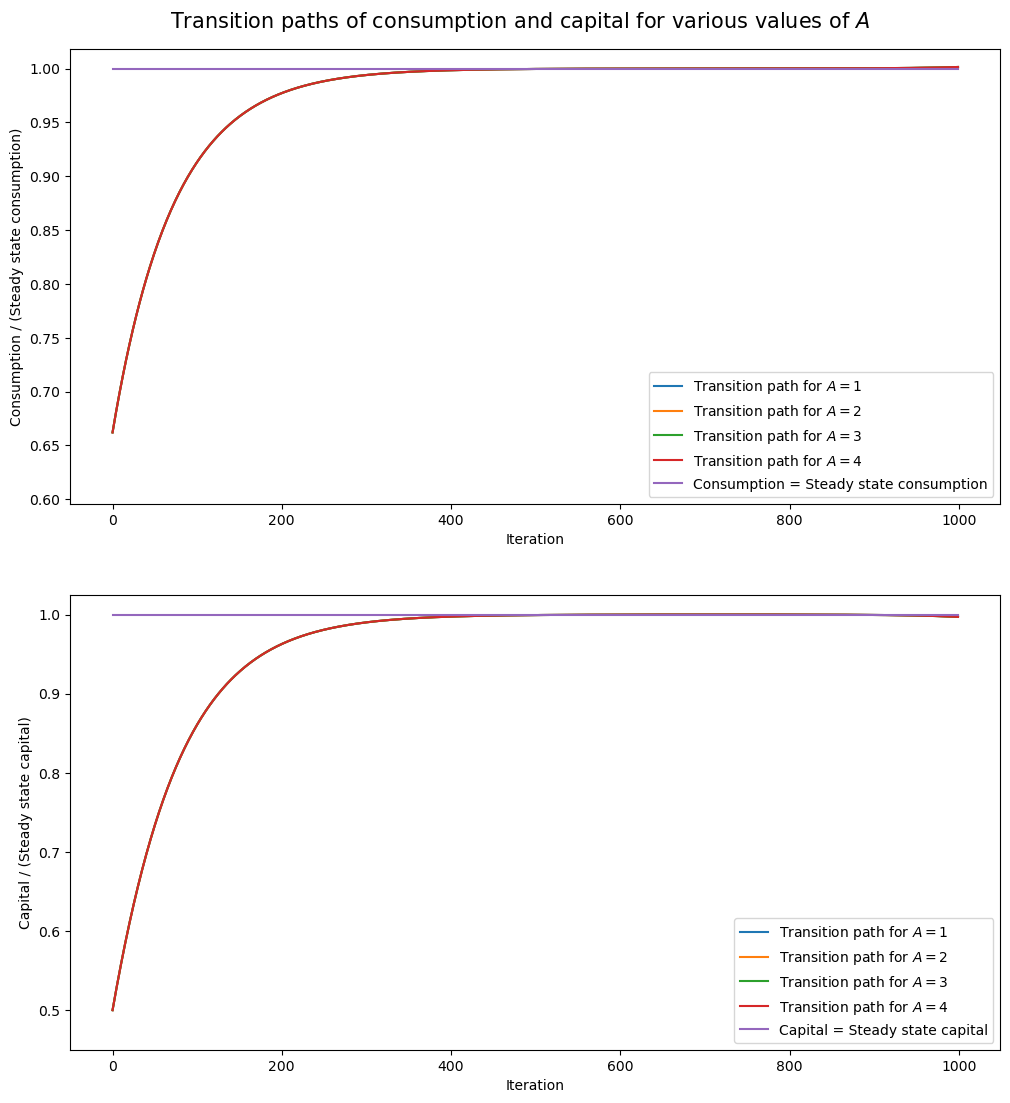

In [14]:
labels = [rf"Transition path for $A={A}$" for A in As]
fig, axs = plt.subplots(2,1,figsize=(12,13))
plot_capital_ratio(k_paths_2d, labels, axs[1])
plot_consumption_ratio(c_paths_2d, labels, axs[0])
fig.suptitle("Transition paths of consumption and capital for various values of $A$", y=0.91, size=15)
fig.savefig("PS2_2d.png")

### Q3

In [15]:
import numpy as np

# Structural parameters
A = 1    # productivity
alfa  = 1/3  # capital share
sigma = 1.01 # CRRA
beta = 0.96
rho   = (1-beta)/beta # discount rate
delta = 0.08 # depreciation rate

# initialise list of capital and consumption paths
k_paths_3a = []
c_paths_3a = []

# solve for cstar, kstar
kstar = ((alfa*A)/(rho+delta))**(1/(1-alfa))
cstar = A*kstar**alfa - delta*kstar

# initial condition
gamma = 1/2
k0 = gamma*kstar # start with gamma the steady state capital stock

# finite diff parameters
dt     = 0.1  # time interval 
N      = 1000  # number of time gridpoints
i      = 0    # set number of iterations to 0
it_max = int(1e4)  # maximum number of iterations to run the algorithm
tol    = 1e-3 # tolerance value for distance to ss
cdist  = 100  # arbitrary initial value of cdist must be greater than ctol
kdist  = 100  # arbitrary initial value of cdist must be greater than ctol

# initialize grids for c and k (preallocation speeds up the algorithm)
c0    = np.zeros((it_max,1)); 
c     = np.zeros((N,it_max+1));
k     = np.zeros((N,it_max+1));

k[0,:] = k0

# initial boundaries for initial guess of consumption
c_under = 0  # c0 cannot be negative
c_over  = A*k0**(alfa) - delta*k0  # c0 should be maximum feasible consumption given k0

while (i < it_max) and (cdist > tol) and (kdist > tol):

    # i. guess c0:
    c0[i] = (c_over+c_under)/2 
    c[0,i]= c0[i]  # update c(1) sequence with new c0 guess

    if i>1 and c0[i] == c0[i-1]:
        break

    # ii. obtain cn and kn by running FD forward in time:
    # exercise: make the code more robust by asserting nonnegativity
    # constraints
    for n in range(N-1):
        c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
        k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]

        if c[n,i] > c[n+1,i]:
            c_under = c0[i][0]
#                 break
        elif k[n,i] > k[n+1,i]:
            c_over  = c0[i][0]
#                 break

    # iii. check for convergence
    if not np.isnan(c[N-1,i]) and not np.isnan(k[N-1,i]):
        cdist = abs(c[N-1,i] - cstar)/(c[N-1,i]+cstar)
        kdist = abs(k[N-1,i] - kstar)/(k[N-1,i]+kstar)

    if sum(c[:,i] > cstar) > 0:
        c_over  = c0[i][0] # if consumption ever exceeds cstar, initial guess of c0 was too high
    elif sum(k[:,i] > kstar) > 0:
        c_under = c0[i][0] # if capital ever exceeds kstar, initial guess of c0 was too low

    i = i + 1 # update count of iterations and try again

k_paths_3a.append(k[:,i-1])
c_paths_3a.append(c[:,i-1])

C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\812208563.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\812208563.py:56: RuntimeWarning: invalid value encountered in scalar power
  c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\812208563.py:57: RuntimeWarning: invalid value encountered in scalar power
  k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]


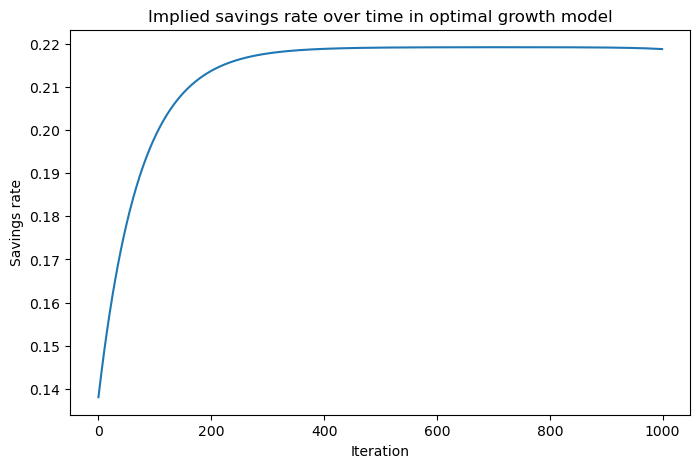

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(delta*k_paths_3a[0]/(A*k_paths_3a[0]**alfa))
ax.set_ylabel("Savings rate")
ax.set_xlabel("Iteration")
ax.set_title("Implied savings rate over time in optimal growth model")
fig.savefig("PS2_3c.png")

In [17]:
import numpy as np

# Structural parameters
A = 1    # productivity
alfa  = 1/3  # capital share
sigma = 1.01 # CRRA
beta = 0.96
rho   = (1-beta)/beta # discount rate
delta = 0.08 # depreciation rate


# solve for cstar, kstar
s = (delta*kstar)/(A*kstar**alfa)
kstar = (delta/(s*A))**(1/(alfa-1))
cstar = (1-s)*A*kstar**alfa

# initial condition
gamma = 1/2
k0 = gamma*kstar # start with gamma the steady state capital stock

k = [k0]
c = [(1-s)*A*k0**alfa]

N = 999

for n in range(N):
    new_k = s*A*k[-1]**alfa+(1-delta)*k[-1]
    new_c = (1-s)*A*k[-1]**alfa
    k.append(new_k)
    c.append(new_c)
    
k_paths_3a.append(k)
c_paths_3a.append(c)
# k_paths_3a.append([_k/kstar for _k in k])
# c_paths_3a.append([_c/cstar for _c in c])

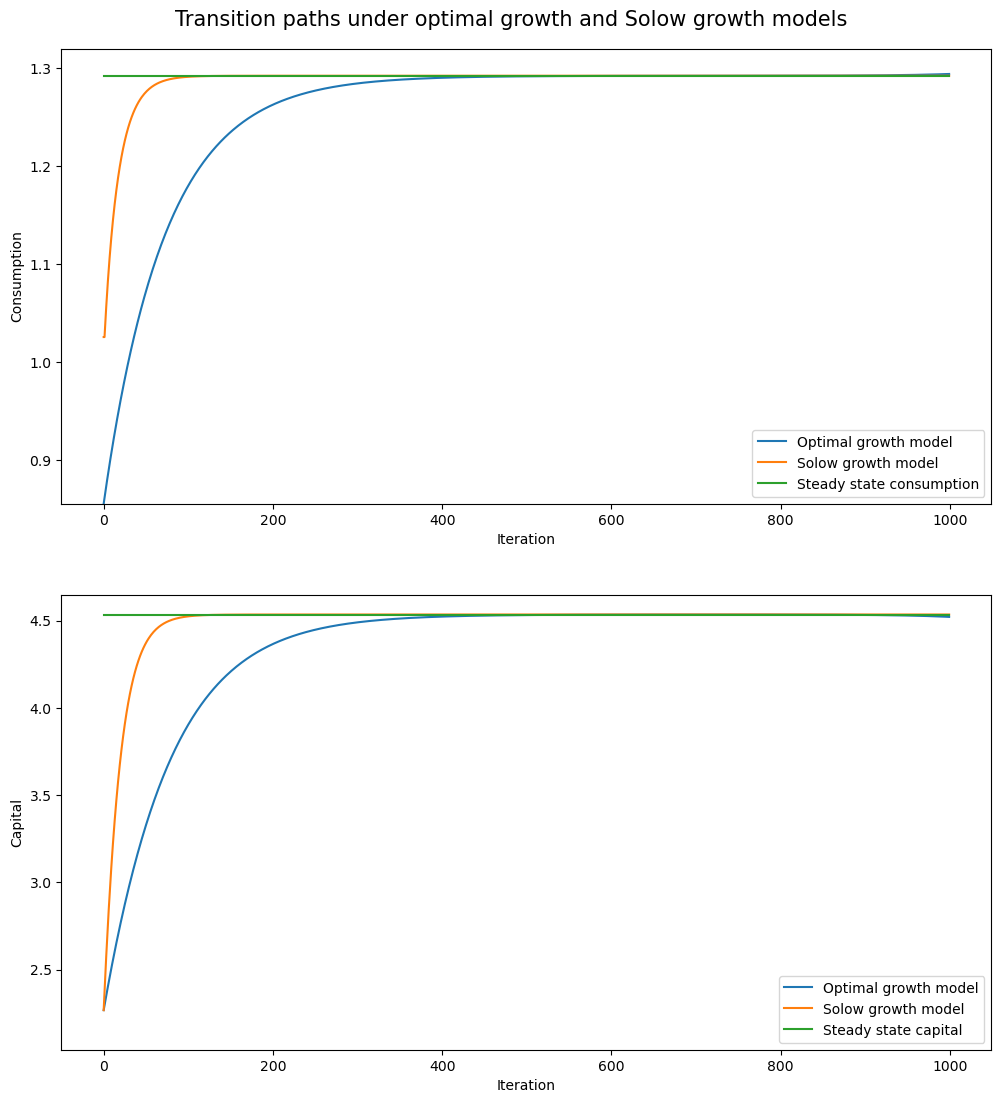

In [18]:
labels = ["Optimal growth model", "Solow growth model"]
fig, axs = plt.subplots(2,1,figsize=(12,13))
plot_capital(k_paths_3a, kstar, labels, axs[1])
plot_consumption(c_paths_3a, cstar, labels, axs[0])
axs[0].set_ylim(top=1.32)
fig.suptitle(r"Transition paths under optimal growth and Solow growth models", y=0.91, size=15)
fig.savefig("PS2_3a.png")

In [19]:
import numpy as np

# Structural parameters
A = 1    # productivity
alfa  = 1/3  # capital share
sigma = 1 # CRRA
beta = 0.96
rho   = (1-beta)/beta # discount rate
delta = 1 # depreciation rate

# initialise list of capital and consumption paths
k_paths_3b = []
c_paths_3b = []

# solve for cstar, kstar
kstar = ((alfa*A)/(rho+delta))**(1/(1-alfa))
cstar = A*kstar**alfa - delta*kstar

# initial condition
gamma = 1/2
k0 = gamma*kstar # start with gamma the steady state capital stock

# finite diff parameters
dt     = 0.1  # time interval 
N      = 1000  # number of time gridpoints
i      = 0    # set number of iterations to 0
it_max = int(1e4)  # maximum number of iterations to run the algorithm
tol    = 1e-3 # tolerance value for distance to ss
cdist  = 100  # arbitrary initial value of cdist must be greater than ctol
kdist  = 100  # arbitrary initial value of cdist must be greater than ctol

# initialize grids for c and k (preallocation speeds up the algorithm)
c0    = np.zeros((it_max,1)); 
c     = np.zeros((N,it_max+1));
k     = np.zeros((N,it_max+1));

k[0,:] = k0

# initial boundaries for initial guess of consumption
c_under = 0  # c0 cannot be negative
c_over  = A*k0**(alfa) - delta*k0  # c0 should be maximum feasible consumption given k0

while (i < it_max) and (cdist > tol) and (kdist > tol):

    # i. guess c0:
    c0[i] = (c_over+c_under)/2 
    c[0,i]= c0[i]  # update c(1) sequence with new c0 guess

    if i>1 and c0[i] == c0[i-1]:
        break

    # ii. obtain cn and kn by running FD forward in time:
    # exercise: make the code more robust by asserting nonnegativity
    # constraints
    for n in range(N-1):
        c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
        k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]

        if c[n,i] > c[n+1,i]:
            c_under = c0[i][0]
#                 break
        elif k[n,i] > k[n+1,i]:
            c_over  = c0[i][0]
#                 break

    # iii. check for convergence
    if not np.isnan(c[N-1,i]) and not np.isnan(k[N-1,i]):
        cdist = abs(c[N-1,i] - cstar)/(c[N-1,i]+cstar)
        kdist = abs(k[N-1,i] - kstar)/(k[N-1,i]+kstar)

    if sum(c[:,i] > cstar) > 0:
        c_over  = c0[i][0] # if consumption ever exceeds cstar, initial guess of c0 was too high
    elif sum(k[:,i] > kstar) > 0:
        c_under = c0[i][0] # if capital ever exceeds kstar, initial guess of c0 was too low

    i = i + 1 # update count of iterations and try again

k_paths_3b.append(k[:,i-1])
c_paths_3b.append(c[:,i-1])

C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\3282175481.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[0,i]= c0[i]  # update c(1) sequence with new c0 guess
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\3282175481.py:56: RuntimeWarning: invalid value encountered in scalar power
  c[n+1, i] = (dt*c[n,i]*1/sigma)*(alfa*A*k[n,i]**(alfa-1) - rho - delta) + c[n,i]
C:\Users\tanay\AppData\Local\Temp\ipykernel_12712\3282175481.py:57: RuntimeWarning: invalid value encountered in scalar power
  k[n+1, i] = dt*(A*k[n,i]**alfa - delta*k[n,i] - c[n,i]) + k[n,i]


In [20]:
import numpy as np

# Structural parameters
A = 1    # productivity
alfa  = 1/3  # capital share
sigma = 1 # CRRA
beta = 0.96
rho   = (1-beta)/beta # discount rate
delta = 1 # depreciation rate


# solve for cstar, kstar
s = (delta*((alfa*A)/(rho+delta))**(1/(1-alfa)))/(A*kstar**alfa)
kstar = (delta/(s*A))**(1/(alfa-1))
cstar = (1-s)*A*kstar**alfa

# initial condition
gamma = 1/2
k0 = gamma*kstar # start with gamma the steady state capital stock

k = [k0]
c = [(1-s)*A*k0**alfa]

N = 999

for n in range(N):
    new_k = s*A*k[-1]**alfa+(1-delta)*k[-1]
    new_c = (1-s)*A*k[-1]**alfa
    k.append(new_k)
    c.append(new_c)
    
k_paths_3b.append(k)
c_paths_3b.append(c)
# k_paths_3b.append([_k/kstar for _k in k])
# c_paths_3b.append([_c/cstar for _c in c])

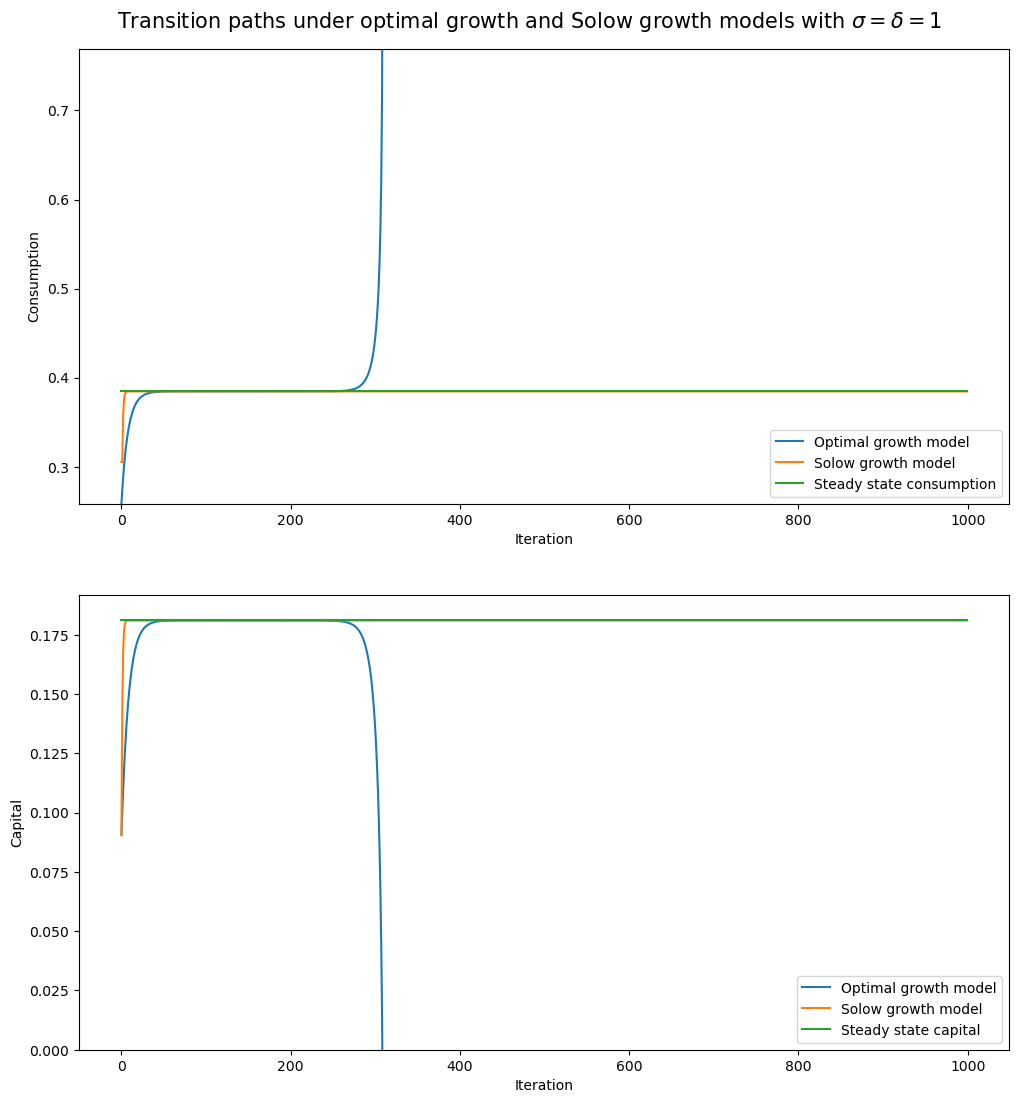

In [21]:
labels = ["Optimal growth model", "Solow growth model"]
fig, axs = plt.subplots(2,1,figsize=(12,13))
plot_capital(k_paths_3b, kstar, labels, axs[1])
plot_consumption(c_paths_3b, cstar, labels, axs[0])
fig.suptitle(r"Transition paths under optimal growth and Solow growth models with $\sigma=\delta=1$", y=0.91, size=15)
fig.savefig("PS2_3b.png")